# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

# Polynomial function generation

In [3]:
superscript_digits = list('⁰¹²³⁴⁵⁶⁷⁸⁹')


def num_superscript(num):
  return ''.join(
      superscript_digits[int(digit)]
      for digit in str(num)
  )


def polynomial_function(degree: int, coefficients: list = None):
  if coefficients is None:
    coefficients = ([1] * degree) + [0]

  assert len(coefficients) == degree + 1, \
      "Number of coefficients should be equal to degree + 1"

  coefficients.reverse()

  power_coeff_pairs = list(enumerate(coefficients))
  power_coeff_pairs.reverse()

  polynomial_str = ' + '.join(f'{coeff}𝑥{num_superscript(power)}' for
                              power, coeff in power_coeff_pairs)

  print(f'Polynomial {degree=}: {polynomial_str}')

  def polynomial(X):
    return sum(coeff * X ** power for
               power, coeff in power_coeff_pairs)

  return polynomial

In [4]:
X = np.array([5])
polynomial_function(0)(X)
polynomial_function(1)(X)
polynomial_function(2)(X)
polynomial_function(3)(X)

Polynomial degree=0: 0𝑥⁰


array([0])

Polynomial degree=1: 1𝑥¹ + 0𝑥⁰


array([5])

Polynomial degree=2: 1𝑥² + 1𝑥¹ + 0𝑥⁰


array([30])

Polynomial degree=3: 1𝑥³ + 1𝑥² + 1𝑥¹ + 0𝑥⁰


array([155])

In [5]:
polynomial_function(0, coefficients=[13])(X)

polynomial_function(1, coefficients=[3, 0])(X)
X * 3

polynomial_function(2, coefficients=[1, 2, 5])(X)
X**2 + 2*X + 5

polynomial_function(3, coefficients=[1, 4, 3, 10])(X)
X**3 + 4*X**2 + 3*X + 10

Polynomial degree=0: 13𝑥⁰


array([13])

Polynomial degree=1: 3𝑥¹ + 0𝑥⁰


array([15])

array([15])

Polynomial degree=2: 1𝑥² + 2𝑥¹ + 5𝑥⁰


array([40])

array([40])

Polynomial degree=3: 1𝑥³ + 4𝑥² + 3𝑥¹ + 10𝑥⁰


array([250])

array([250])

# Noised data generation

In [6]:
def calculate_loss(y1, y2):
  mae = mean_absolute_error(y1, y2)
  mse = mean_squared_error(y1, y2)
  print(f'Mean Absolute Error (MAE): {mae:,.2f}')
  print(f'Mean Squared Error (MSE): {mse:,.2f}')

In [7]:
def plot_scatter_with_line(X, y1, y2, y1_label, y2_label):
  plt.scatter(X, y1, label=y1_label)
  plt.plot(X, y2, color='red', label=y2_label)
  plt.title(f'Scatter Plot of {y1_label} and {y2_label}')
  plt.xlabel("X values")
  plt.ylabel("y values")
  plt.legend()

  print()
  print(f'Loss between {y1_label} and {y2_label}:')
  calculate_loss(y1, y2)
  plt.show()

In [8]:
def random_deviation(deviation):
  return np.random.choice([np.random.uniform(-deviation, 0), np.random.uniform(0, deviation)])


def generate_noised_data(func, X_range, deviation):
  X = np.arange(X_range[0], X_range[1]+1).astype(float)
  y_original = func(X)
  y_noised = np.array([y - y * random_deviation(deviation)
                       for y in y_original])

  plot_scatter_with_line(X, y_noised, y_original, 'Noised y', 'Original y')
  return X, y_noised, y_original

Polynomial degree=0: 0𝑥⁰



Loss between Noised y and Original y:
Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00


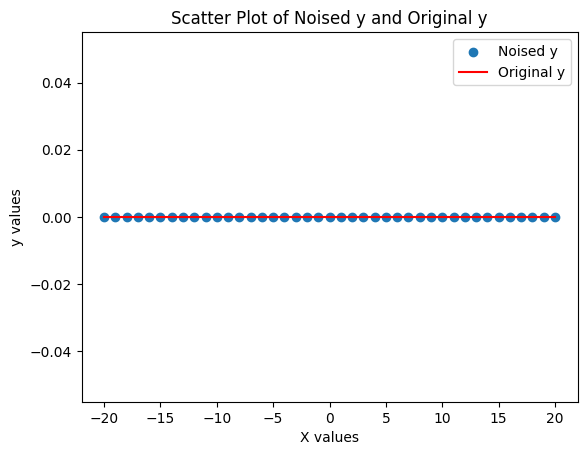

Polynomial degree=1: 1𝑥¹ + 0𝑥⁰

Loss between Noised y and Original y:
Mean Absolute Error (MAE): 2.76
Mean Squared Error (MSE): 13.45


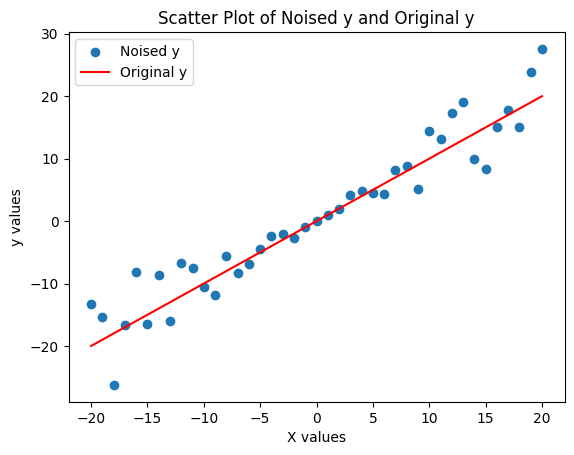

Polynomial degree=2: 1𝑥² + 1𝑥¹ + 0𝑥⁰

Loss between Noised y and Original y:
Mean Absolute Error (MAE): 38.83
Mean Squared Error (MSE): 3,364.79


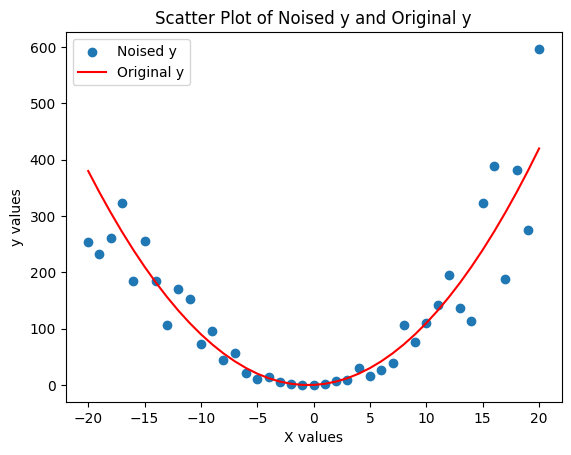

Polynomial degree=3: 1𝑥³ + 1𝑥² + 1𝑥¹ + 0𝑥⁰

Loss between Noised y and Original y:
Mean Absolute Error (MAE): 469.07
Mean Squared Error (MSE): 693,328.43


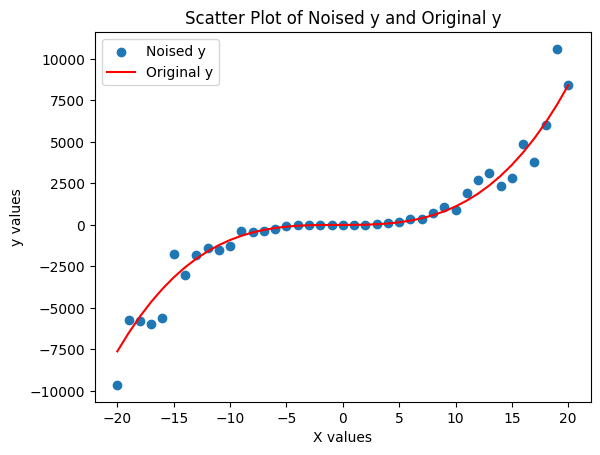

In [9]:
_ = generate_noised_data(polynomial_function(0), (-20, 20), 0.5)
_ = generate_noised_data(polynomial_function(1), (-20, 20), 0.5)
_ = generate_noised_data(polynomial_function(2), (-20, 20), 0.5)
_ = generate_noised_data(polynomial_function(3), (-20, 20), 0.5)

# Polynomial regression

In [10]:
def polynomial_feature_transform(X, degree):
  poly = PolynomialFeatures(degree=degree, include_bias=True)
  X_poly = poly.fit_transform(X.reshape(-1, 1))
  return X_poly

In [11]:
def build_polynomial_model(learning_rate, degree):
  model = Sequential([
      Input(shape=(degree + 1,)),
      Dense(units=1)
  ])
  model.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=MeanSquaredError(),
                metrics=[RootMeanSquaredError()])
  return model

In [12]:
def plot_regression_results(X, y_noised, y_pred):
  plot_scatter_with_line(X, y_noised, y_pred, 'Noised y', 'Predicted y')

In [13]:
def plot_loss_curve(history):
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], color='blue', label='Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training Loss Curve')
  plt.legend()
  plt.grid(True)
  plt.show()

In [14]:
def polynomial_regression(X, y, degree=1, learning_rate=0.1, epochs=50, batch_size=1, verbose=False):
  model = build_polynomial_model(learning_rate=learning_rate, degree=degree)

  X_poly = polynomial_feature_transform(X, degree)
  history = model.fit(X_poly, y, epochs=epochs,
                      batch_size=len(y)*batch_size, verbose=verbose)
  y_pred = model.predict(X_poly, verbose=verbose)

  learned_weights, learned_bias = model.get_weights()
  manually_calculated_predictions = [learned_bias + np.dot(feature, learned_weights)
                                     for feature in X_poly]
  mae = mean_absolute_error(y_pred, manually_calculated_predictions)
  print(
      f"MAE between model predictions and manually calculated predictions: {mae:.2f}")

  plot_regression_results(X, y, y_pred)
  plot_loss_curve(history)

Polynomial degree=3: 1𝑥³ + 1𝑥² + 1𝑥¹ + 0𝑥⁰

Loss between Noised y and Original y:
Mean Absolute Error (MAE): 714.66
Mean Squared Error (MSE): 1,523,864.37


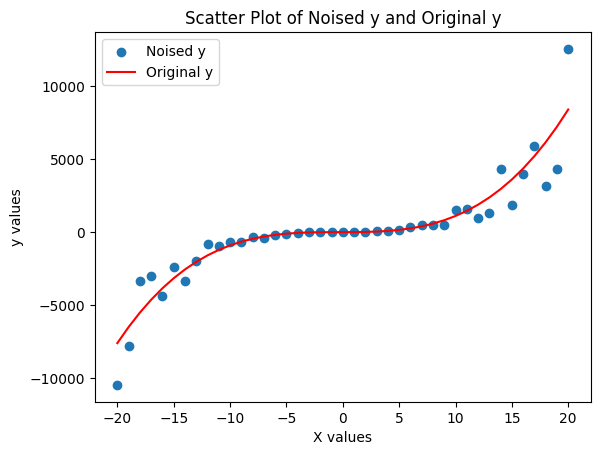

MAE between model predictions and manually calculated predictions: 0.00

Loss between Noised y and Predicted y:
Mean Absolute Error (MAE): 712.78
Mean Squared Error (MSE): 1,510,503.34


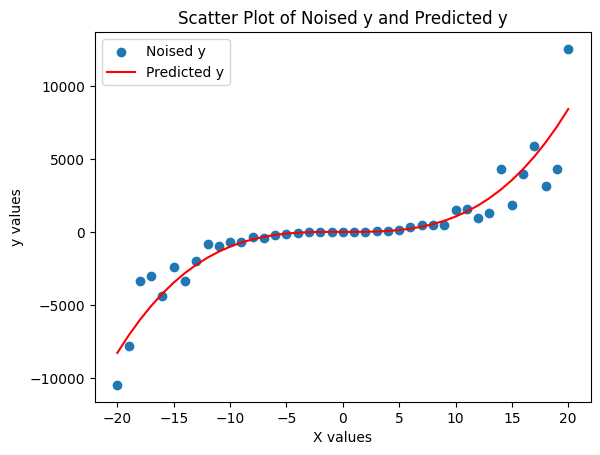

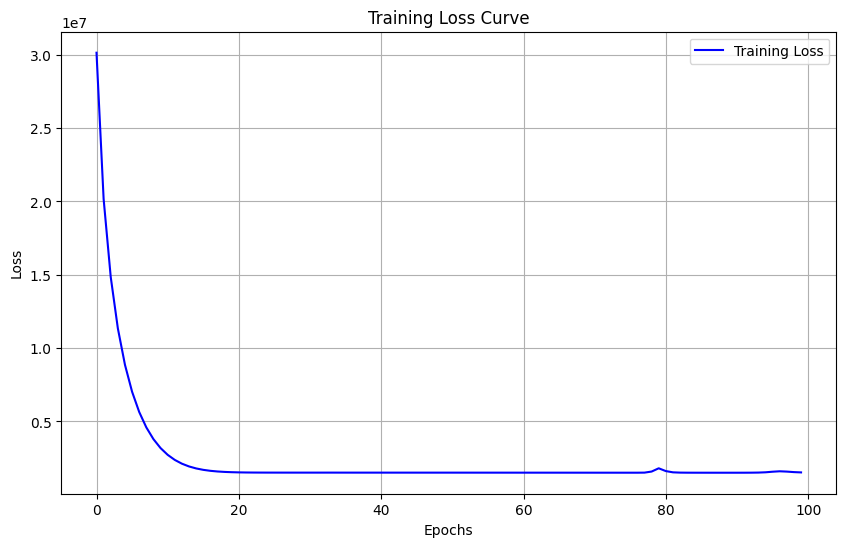

In [19]:
X, y_noised, y_original = generate_noised_data(polynomial_function(3),
                                               [-20, 20], 0.5)
polynomial_regression(
    X, y_noised, degree=3, learning_rate=0.1, epochs=100)

# Linear regression $(mx + b)$

In [21]:
def build_linear_model(learning_rate):
  model = Sequential([
      Input(shape=(1,)),
      Dense(units=1)
  ])
  model.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=MeanSquaredError(),
                metrics=[RootMeanSquaredError()])
  return model

In [22]:
def linear_regression(X, y, learning_rate=0.1, epochs=50, batch_size=1, verbose=False):
  model = build_linear_model(learning_rate=learning_rate)

  history = model.fit(X, y, epochs=epochs,
                      batch_size=len(y)*batch_size, verbose=verbose)
  y_pred = model.predict(X, verbose=verbose)

  learned_weights, learned_bias = model.get_weights()
  manually_calculated_predictions = [learned_bias + np.dot(feature, learned_weights)
                                     for feature in X.reshape(-1, 1)]
  mae = mean_absolute_error(y_pred, manually_calculated_predictions)
  print(
      f"MAE between model predictions and manually calculated predictions: {mae:.2f}")
  print(f'{learned_weights=} {learned_bias=}')

  plot_regression_results(X, y, y_pred)
  plot_loss_curve(history)

Polynomial degree=1: 3𝑥¹ + 1𝑥⁰

Loss between Noised y and Original y:
Mean Absolute Error (MAE): 29.21
Mean Squared Error (MSE): 1,539.56


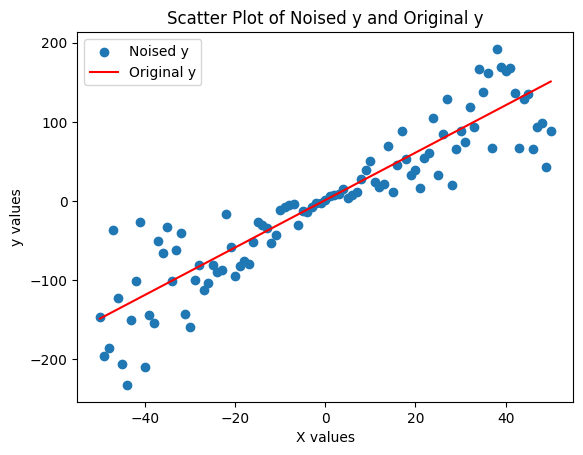

MAE between model predictions and manually calculated predictions: 0.00
learned_weights=array([[2.957017]], dtype=float32) learned_bias=array([-3.7173092], dtype=float32)

Loss between Noised y and Predicted y:
Mean Absolute Error (MAE): 29.08
Mean Squared Error (MSE): 1,515.74


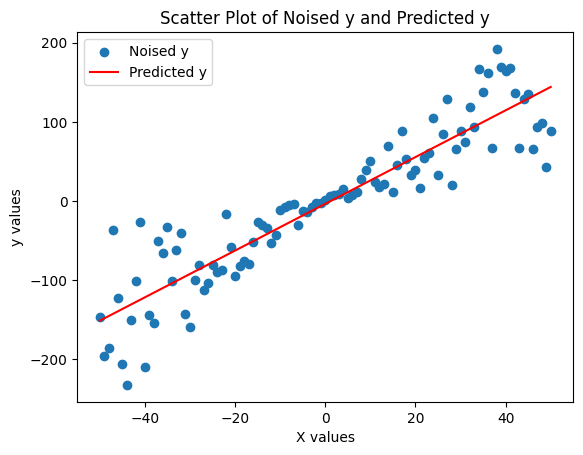

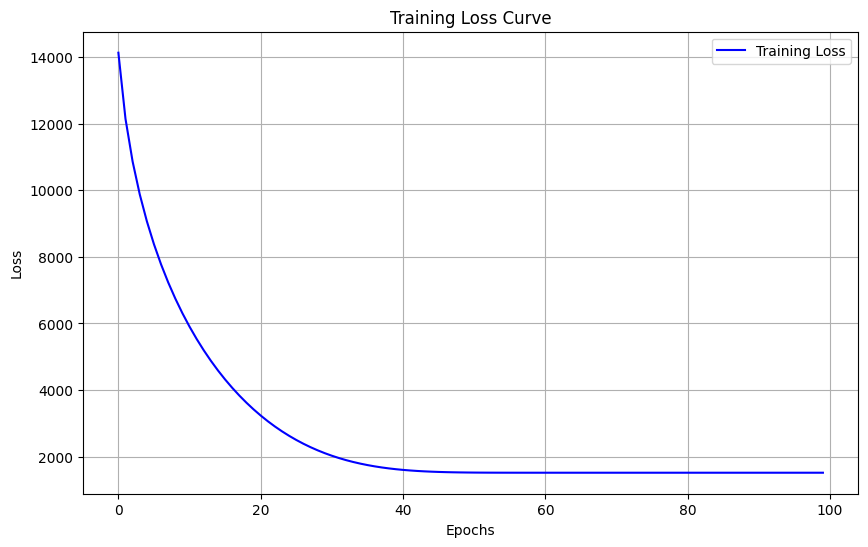

In [24]:
X, y_noised, y_original = generate_noised_data(polynomial_function(1, [3, 1]),
                                               [-50, 50], 0.8)
linear_regression(
    X, y_noised, learning_rate=0.1, epochs=100)